## 1. Импортирование требуемых библиотек

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from math import inf
import math
import heapq
import time
%matplotlib inline

## 2. Вспомогательные функции

Ниже приведён код класса, который описывает исследуемую карту. Данная карта считывается из файла, где на первой строке указаны размеры карты, потом идут строки, которые позволяют определить, является ли клетка проходимой, или непроходимой. Последняя строка содержит координаты началой и конечной точек

In [ ]:
class Map:
    def __init__(self):
        self._width = 0
        self._height = 0
        self._cells = []

    def read_task_from_file(self, path):
        tasks_file = open(path)
        width, height = tasks_file.readline().split('\t')
        self._width, self._height = int(width), int(height.strip())
        self._cells = [[0 for _ in range(self._width)] for _ in range(self._height)]
        i = 0
        j = 0
        for line in tasks_file:
            j = 0
            for cell in line:
                if cell == '.':
                    self._cells[i][j] = 0
                elif cell in ['@', 'T']:
                    self._cells[i][j] = 1
                else:
                    continue
                j += 1
            if j != self._width:
                raise Exception('Size Error. Map width = ', j, ', but must be', width, '(map line: ', i, ')')
            i += 1
            if(i == self._height):
                break
        start_i, start_j, goal_i, goal_j = tasks_file.readline().split('\t')
        return (int(start_i), int(start_j)), (int(goal_i), int(goal_j))


    def in_bounds(self, i, j):
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors
    
    def get_predecessors(self, i, j):
        predecessors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        for d in delta:
            if self.in_bounds(i - d[0], j - d[1]) and self.traversable(i - d[0], j - d[1]):
                predecessors.append((i - d[0], j - d[1]))
        return predecessors
            
    def get_size(self):
        return (self._height, self._width)

    def show_difference(self, other_map):
        changed_cells = []
        for i in range(self._height):
            for j in range(self._width):
                if self._cells[i][j] != other_map._cells[i][j]:
                    changed_cells.append((i, j))
        return changed_cells

    def open_cells(self, real_map, i, j):
        changed_cells = []
        if not self._cells:
            self._width = real_map._width
            self._height = real_map._height
            self._cells = [[0 for _ in range(self._width)] for _ in range(self._height)]
        delta = [[0, 1], [1, 0], [0, 0], [0, -1], [-1, 0], [1, 1], [-1, -1], [-1, 1], [1, -1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]):
                if self._cells[i + d[0]][j + d[1]] != real_map._cells[i + d[0]][j + d[1]]:
                    self._cells[i + d[0]][j + d[1]] = real_map._cells[i + d[0]][j + d[1]]
                    changed_cells.append((i + d[0], j + d[1]))
        
        return changed_cells

Функция compute_cost вычисляет расстояние между соседними клетками. Если одна из клеток является препятствием - то такое расстояние равно 0. Иначе - 1

In [ ]:
def compute_cost(grid, i1, j1, i2, j2):
    if grid.traversable(i1, j1) and grid.traversable(i2, j2):
        if abs(i1 - i2) + abs(j1 - j2) == 1:
            return 1
    return 0

Функция draw выводит изображение карты, которая подаётся ей на вход. Помимо этого подаются координаты начала и конца пути, сами координаты пути и координаты рассмотренных клеток

In [ ]:
def draw(grid_map, start = None, goal = None, path = None, nodes_opened = None):
    k = 15
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node[1] * k, node[0] * k, (node[1] + 1) * k - 1, (node[0] + 1) * k - 1), fill='gray', width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step[0], step[1])):
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step[1] * k, step[0] * k, (step[1] + 1) * k - 1, (step[0] + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start[0], start[1])):
        draw.rectangle((start[1] * k, start[0] * k, (start[1] + 1) * k - 1, (start[0] + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (grid_map.traversable(goal[0], goal[1])):
        draw.rectangle((goal[1] * k, goal[0] * k, (goal[1] + 1) * k - 1, (goal[0] + 1) * k - 1), fill=(231, 76, 60), width=0)
        
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=0)

    for x in range(k, w_im, k):
        line = ((x, 0), (x, h_im))
        draw.line(line, fill=0)

    for y in range(k, h_im, k):
        line = ((0, y), (w_im, y))
        draw.line(line, fill=0)

    _, ax = plt.subplots(dpi=200)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

Функция test позволяет запускать алгоритмы и выводить для них результаты. В качестве входных параметров подаётся алгоритм, который будет искать путь, подаётся путь к директории с картами (данная директория обязательно должна содержать папки old_maps и updated_maps), подаётся число экспериментов (число файлов, которые содержатся в каждой папке), размер карт, флаг, который обозначает, хотим ли мы строить карты, с обозначенными на них маршрутами, а также подаётся функция эвристики. Результатом работы такой функции является вывод картинки с изображённым на ней путём (если был передан соответствующий флаг) и различная статистическая информация - время выполнения алгоритма, длина пути, число рассмотренных узлов

In [ ]:
def test(search_func, data_path, num_of_tasks=None, map_size=32, beautiful_output=False, *args):
    if (num_of_tasks is None) or (num_of_tasks<=0):
        print('Incorrect number of tasks!')
        return

    if map_size not in [32, 64, 128]:
        print('Incorrect map size. Select from (32, 64, 128)!')
        return
    
    task_num = num_of_tasks
    stat_all = []
    for task_count in range(task_num):
        start_time = time.time()
        task_maps = [Map(), Map()]
        task_1_name = data_path + 'old_maps/' + str(task_count) + '_' + str(map_size) + '.map'
        task_2_name = data_path + 'updated_maps/' + str(task_count) + '_' + str(map_size) + '.map'
        start, goal = task_maps[0].read_task_from_file(task_1_name)
        start, goal = task_maps[1].read_task_from_file(task_2_name)
        if search_func.__name__ == 'lpa':
            stats = search_func(task_maps, start[0], start[1], goal[0], goal[1], *args)
        else:
            stats = []
            for i in range(len(task_maps)):
                stats.append(search_func(task_maps[i], start[0], start[1], goal[0], goal[1], *args))
        for i, stat in enumerate(stats):
            if stat is None:
                print('Path not found!')
                continue
            stat_all.append(stat)
            path, p_length, vertices = stat
            
            if beautiful_output:
                if i > 0:
                    print('Map Update', i)
                else:
                    print('Original Map')
                print(f'Length {p_length}')
                print(f'Nodes opened {len(vertices)}')
                draw(task_maps[i], start, goal, path, vertices)
            else:
                print(f'Nodes opened: {len(vertices)}')
                print(f'Length: {p_length}')
        elapsed_time = time.time()
        if beautiful_output:
            print('Elapsed Time', elapsed_time - start_time)
            print()
        else:
            print(elapsed_time - start_time)

    return stat_all

В качестве функции эвристики используется расстояние городских кварталов (манхэттенское расстояние)

In [ ]:
def manhattan_distance(i1, j1, i2, j2):
    return abs(i1 - i2) + abs(j1 - j2)

Класс очереди, разработанный под алгоритмы LPA* и D* Lite



In [ ]:
class PriorityQueue:
    def  __init__(self):
        self.heap = []
        self.count = 0

    def push(self, item, priority):
        entry = (priority, self.count, item)
        heapq.heappush(self.heap, entry)
        self.count += 1

    def pop(self):
        (_, _, item) = heapq.heappop(self.heap)
        return item

    def topKey(self):
        if self.isEmpty():
            return (inf, inf)
        return self.heap[0][0]

    def remove(self, p):
        rem = (-inf, -inf)
        self.update(p, rem)
        a = self.pop()

    def isEmpty(self):
        return len(self.heap) == 0

    def update(self, item, priority):
        for index, (p, c, i) in enumerate(self.heap):
            if i == item:
                if p <= priority:
                    break
                del self.heap[index]
                self.heap.append((priority, c, item))
                heapq.heapify(self.heap)
                break
        else:
            self.push(item, priority)

Класс очереди, разработанный под алгоритм A*

In [ ]:
class PriorityQueueAstar:
    
    def __init__(self):
        self._open = []
        self._closed = set()
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)

    def open_is_empty(self):
        return not self._open

    def add_to_open(self, item):
        heapq.heappush(self._open, item)
        return    

    def get_best_node_from_open(self):
        best = heapq.heappop(self._open)
        while self.was_expanded(best):
            if self.open_is_empty():
                return None
            self._enc_open_dublicates += 1
            best = heapq.heappop(self._open)
        return best

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed


## 2. Реализация базового алгоритма A*

На вход функция astar получает саму карту, координаты начала и конца пути, а также функцию эвристики. Выходом работы такого алгоритма является None - если путь не найден и координаты пути, длина пути, координаты рассмотренных узлов - если путь был определён

In [ ]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None):

    class Node:
        def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
            self.i = i
            self.j = j
            self.g = g
            self.h = h
            if f is None:
                self.f = self.g + h
            else:
                self.f = f        
            self.parent = parent

        def __eq__(self, other):
            return (self.i == other.i) and (self.j == other.j)
        
        def __hash__(self):
            ij = self.i, self.j
            return hash(ij)

        def __lt__(self, other):
            return self.f < other.f

    def make_path(goal):
        length = goal.g
        current = goal
        path = []
        while current.parent:
            path.append((current.i, current.j))
            current = current.parent
        return path[::-1], length

    ast = PriorityQueueAstar()
    stats = None
    nodes_opened = []

    s_start = Node(start_i, start_j, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    s_goal = Node(goal_i, goal_j)
    ast.add_to_open(s_start)
    while not ast.open_is_empty():
        search = ast.get_best_node_from_open()
        if search is None:
           break
        if search == s_goal:
            way, length = make_path(search)
            stats = (way, length, nodes_opened)
            break

        successors_coords = grid_map.get_neighbors(search.i, search.j)
        for coords in successors_coords:
            s = Node(coords[0], coords[1])
            if ast.was_expanded(s):
                continue
            s.g = search.g + compute_cost(grid_map, search.i, search.j, coords[0], coords[1])
            s.h = heuristic_func(coords[0], coords[1], goal_i, goal_j)
            s.f = s.g + s.h
            s.parent = search
            ast.add_to_open(s)
            s_coords = (s.i, s.j)
            if s_coords not in nodes_opened:
                nodes_opened.append(s_coords)

        ast.add_to_closed(search)      
    
    return stats

## 3. Реализация алгоритма LPA*

На вход функция lpa получает набор карт, координаты начала и конца пути, а также функцию эвристики. В набор карт входит оригинальная карта, а также её измененные состояния. Выходом работы такого алгоритма является None - если путь не найден и координаты пути, длина пути, координаты рассмотренных узлов для каждой карты - если путь был определён

In [ ]:
def lpa(grid_maps, start_i, start_j, goal_i, goal_j, heuristic_func = None):
    queue = PriorityQueue()
    rhs = {}
    g = {}
    s0 = (start_i, start_j)
    sg = (goal_i, goal_j)
    
    def calculateKey(s):
        return min(g[s], rhs[s]) + heuristic_func(s[0], s[1], sg[0], sg[1]), min(g[s], rhs[s])
    
    def initialize(grid_map):
        map_size = grid_map.get_size()
        for i in range(map_size[0]):
            for j in range(map_size[1]):
              rhs[(i, j)] = inf
              g[(i, j)] = inf
        rhs[s0] = 0
        queue.push(s0, calculateKey(s0))

    def updateVertex(next_state, grid_map):
        updated = False
        if next_state != s0:
            successors = grid_map.get_neighbors(next_state[0], next_state[1])
            tmp = inf
            for s in successors:
                tmp = min(tmp, g[s] + compute_cost(grid_map, s[0], s[1], next_state[0], next_state[1]))
            rhs[next_state] = tmp
        queue.remove(next_state)
        if g[next_state] != rhs[next_state]:
            updated = True
            queue.push(next_state, calculateKey(next_state))

        return updated

    def computeShortestPath(grid_map):
        pathFound = False
        nodes_opened = []
        while queue.topKey() < calculateKey(sg) or rhs[sg] != g[sg]:
            q = queue.pop()
            next_states = grid_map.get_neighbors(q[0], q[1])
            if g[q] > rhs[q]:
                g[q] = rhs[q]
                for s in next_states:
                    upd = updateVertex(s, grid_map)
                    if upd:
                        if s not in nodes_opened:
                            nodes_opened.append(s)
            else:
                g[q] = inf
                next_states.append(q)
                for s in next_states:
                    upd = updateVertex(s, grid_map)
                    if upd:
                       if s not in nodes_opened:
                          nodes_opened.append(s)
        if g[sg] != inf:
           pathFound = True

        return pathFound, nodes_opened
    
    def createPath(goal, grid_map):
        way = []
        length = g[goal]
        m = 0
        while goal != s0:
            temp = 99999
            minState = None
            way.append(goal)
            next_states = grid_map.get_neighbors(goal[0], goal[1])
            for s in next_states:
                if temp > g[s]:
                    temp = g[s]
                    minState = s
            goal = minState

        way.append(goal)
        return way[::-1], length
    
    initialize(grid_maps[0])
    stats = []
    
    for i, grid_map in enumerate(grid_maps):
        if i != 0:
            changed_cells = grid_map.show_difference(grid_maps[i-1])
            for u in changed_cells:
                updateVertex(u, grid_map)
        pathFound, nodes_opened = computeShortestPath(grid_map)
        if pathFound:
           way, length = createPath(sg, grid_map)
           stats.append((way, length, nodes_opened))
        else:
           stats.append(None)

    return stats

## 4. Реализация алгоритма D* Lite

На вход функция dstar получает саму карту, координаты начала и конца пути, а также функцию эвристики. Выходом работы такого алгоритма является None - если путь не найден и координаты пути, длина пути, координаты рассмотренных узлов для переданной в качестве входного параметра карты - если путь был определён

In [ ]:
def dstar(grid_map_real, start_i, start_j, goal_i, goal_j, heuristic_func = None):
    queue = PriorityQueue()
    rhs = {}
    g = {}
    s_start = (start_i, start_j)
    s_goal = (goal_i, goal_j)
    k_m = 0

    def setKm():
        k_m = 0
    
    def calculateKey(s):
        calculated_key = (min(g[s], rhs[s]) + heuristic_func(s_start[0], s_start[1], s[0], s[1]) + k_m, min(g[s], rhs[s]))
        setKm()
        return calculated_key
    
    def initialize(grid_map):
        map_size = grid_map.get_size()
        for i in range(map_size[0]):
            for j in range(map_size[1]):
              rhs[(i, j)] = inf
              g[(i, j)] = inf
        rhs[s_goal] = 0
        queue.push(s_goal, calculateKey(s_goal))

    def updateVertex(u, grid_map):
        updated = False
        if u != s_goal:
            successors = grid_map.get_neighbors(u[0], u[1])
            tmp = inf
            for s in successors:
                tmp = min(tmp, compute_cost(grid_map, u[0], u[1], s[0], s[1]) + g[s])
            rhs[u] = tmp
        queue.remove(u)
        if g[u] != rhs[u]:
            updated = True
            queue.push(u, calculateKey(u))
        return updated

    def computeShortestPath(grid_map):
        while (queue.topKey() < calculateKey(s_start)) or (rhs[s_start] != g[s_start]):
            k_old = queue.topKey()
            u = queue.pop()
            if k_old < calculateKey(u):
                queue.push(u, calculateKey(u))
            elif g[u] > rhs[u]:
                g[u] = rhs[u]
                predecessors = grid_map.get_predecessors(u[0], u[1])
                for s in predecessors:
                    upd = updateVertex(s, grid_map)
                    if upd:
                        if s not in nodes_opened:
                            nodes_opened.append(s)
            else:
                g[u] = inf
                predecessors = grid_map.get_predecessors(u[0], u[1])
                predecessors.append(u)
                for s in predecessors:
                    upd = updateVertex(s, grid_map)
                    if upd:
                       if s not in nodes_opened:
                          nodes_opened.append(s)
        return nodes_opened
    
    way = [s_start]
    nodes_opened = []
    s_last = s_start
    grid_map = Map()

    grid_map.open_cells(grid_map_real, s_start[0], s_start[1])
    initialize(grid_map)
    nodes_opened = computeShortestPath(grid_map)

    while s_start != s_goal:
        if g[s_start] == inf:
            return None
            
        min_g = inf
        argmin = None
        successors = grid_map.get_neighbors(s_start[0], s_start[1])
        for s in successors:
            tmp = g[s] + compute_cost(grid_map, s_start[0], s_start[1], s[0], s[1])
            if tmp < min_g:
                min_g = tmp
                argmin = s

        s_start = argmin
        changed_cells = grid_map.open_cells(grid_map_real, s_start[0], s_start[1])
        if changed_cells:
            k_m += heuristic_func(s_last[0], s_last[1], s_start[0], s_start[1])
            s_last = s_start
            for u in changed_cells:
                updateVertex(u, grid_map)
        way.append(s_start)
        nodes_opened = computeShortestPath(grid_map)

    return (way, len(way), nodes_opened)

## 5. Реализация изменённого алгоритма алгоритма A*, предназначенного для нахождения пути в неизвестной местности

На вход функция astar_in_dstar_style получает саму карту, координаты начала и конца пути, а также функцию эвристики. Выходом работы такого алгоритма является None - если путь не найден и координаты пути, длина пути, координаты рассмотренных узлов - если путь был определён. Отличие данной функции от astar - если astar_in_dstar_style при воспроизведении короткого пути наткнётся на неоткрытое ранее припятствие, то необходимо заново искать короткий путь

In [ ]:
def astar_in_dstar_style(grid_map_real, start_i, start_j, goal_i, goal_j, heuristic_func = None):
    queue = PriorityQueue()
    s_start = (start_i, start_j)
    s_goal = (goal_i, goal_j)
    
    way = [s_start]
    nodes_opened = []
    s_last = s_start
    grid_map = Map()

    grid_map.open_cells(grid_map_real, s_start[0], s_start[1])
    stats = astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func)
    path, length, nodes_opened = stats
    vertices = nodes_opened
    k = 0

    while s_start != s_goal:
        
        if stats:
           grid_map.open_cells(grid_map_real, s_start[0], s_start[1])
           next_state = path[k]
           if not grid_map.traversable(next_state[0], next_state[1]):
              k = 0
              stats = astar(grid_map, s_start[0], s_start[1], goal_i, goal_j, heuristic_func)
              if stats:
                 path, length, nodes_opened = stats
                 vertices += nodes_opened
              else:
                 return None
           else:
             s_start = next_state
             way.append(s_start)
             k += 1
        else:
          return None

    return (way, len(way), vertices)

## 6. Примеры запусков тестов

Пример запуска тестов для алгоритма LPA*: проверим, как меняется количество раскрытий вершин при итеративном поиске пути на парах (Original Map, Updated Map) - исходная карта и измененная.

Original Map
Length 63
Nodes opened 1041


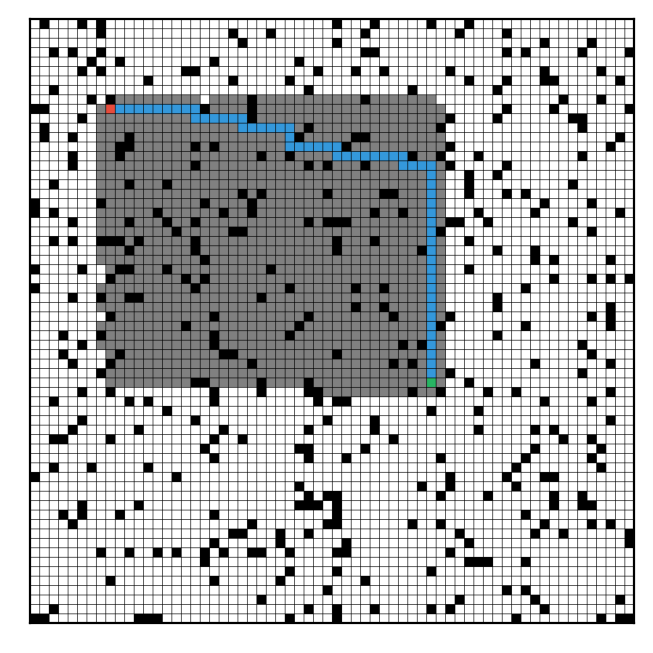

Map Update 1
Length 63
Nodes opened 12


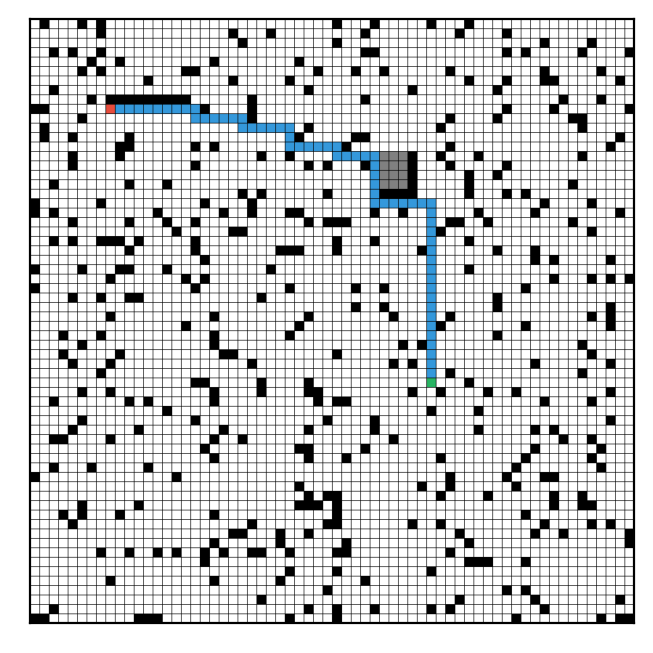

Elapsed Time 0.7195284366607666

Original Map
Length 46
Nodes opened 270


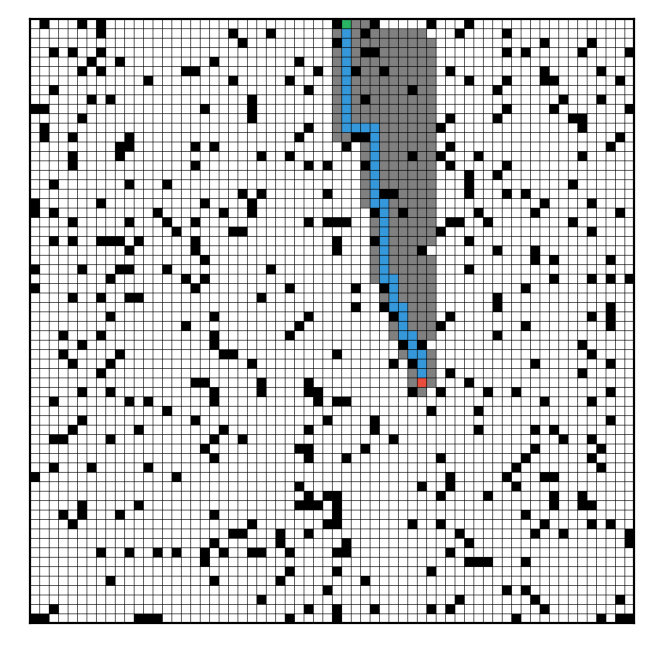

Map Update 1
Length 46
Nodes opened 41


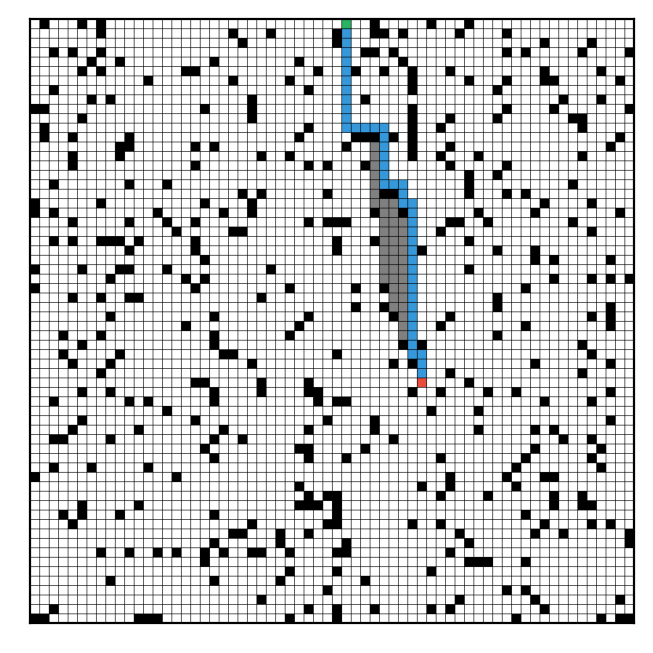

Elapsed Time 0.6792871952056885

Original Map
Length 51
Nodes opened 331


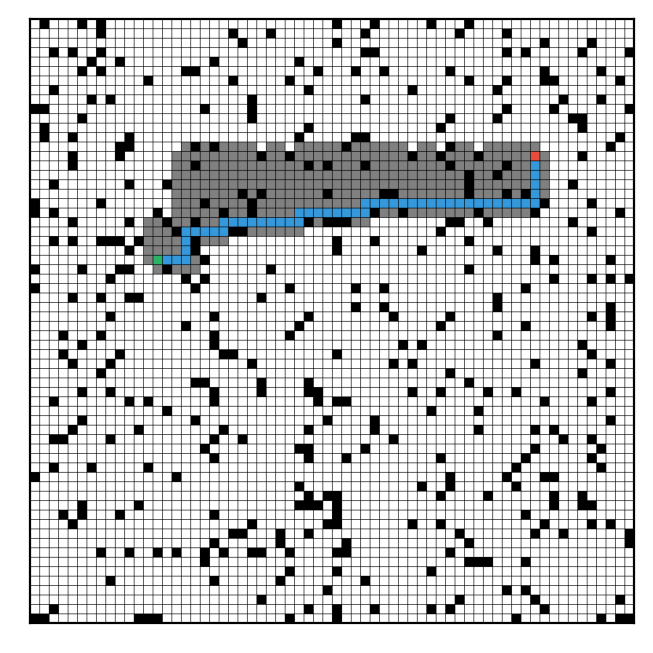

Map Update 1
Length 51
Nodes opened 44


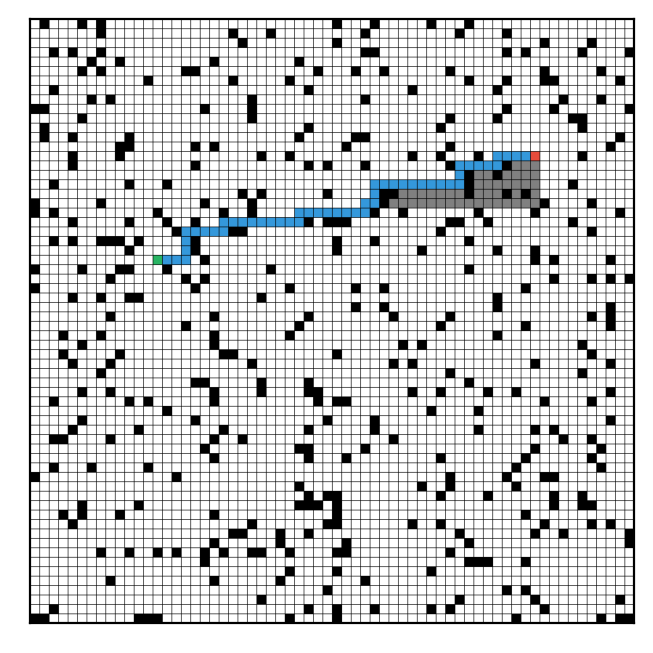

Elapsed Time 0.6354568004608154

Original Map
Length 97
Nodes opened 2039


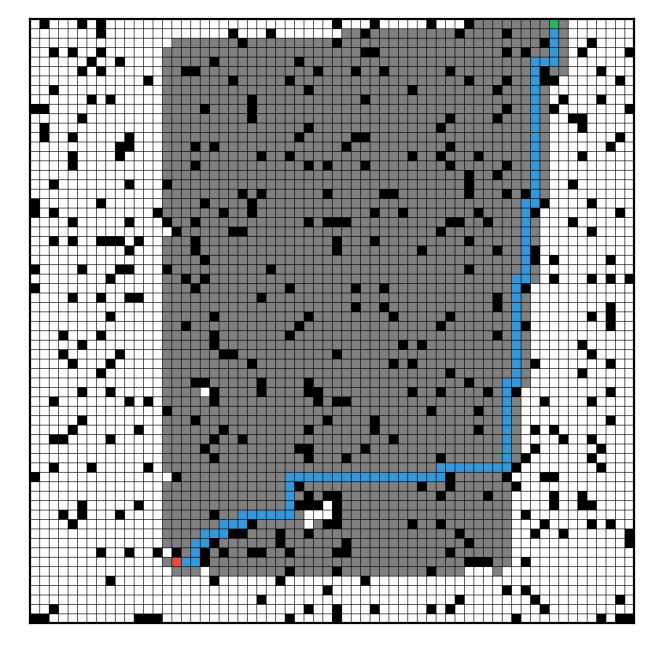

Map Update 1
Length 97
Nodes opened 122


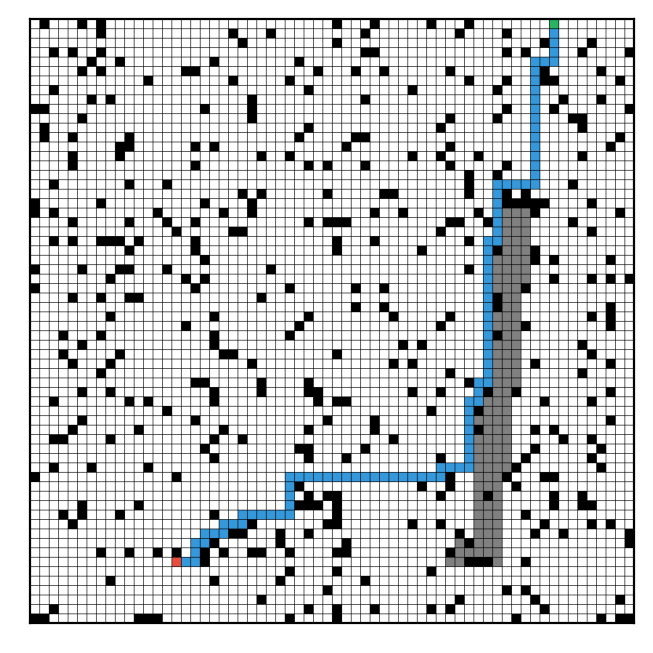

Elapsed Time 0.9720749855041504

Original Map
Length 28
Nodes opened 243


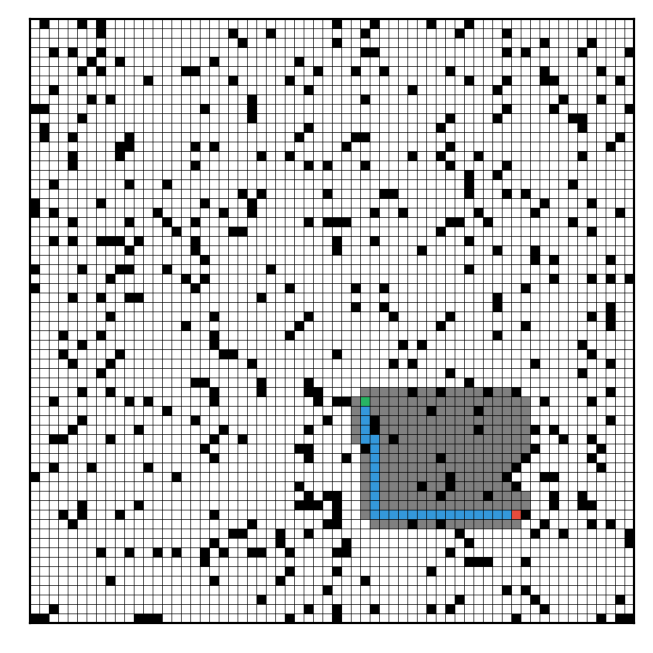

Map Update 1
Length 28
Nodes opened 17


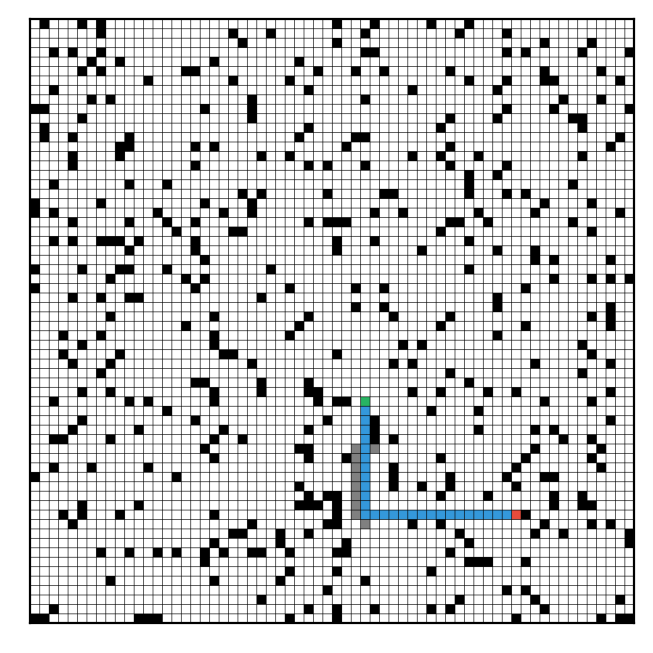

Elapsed Time 0.6276254653930664

Original Map
Length 52
Nodes opened 561


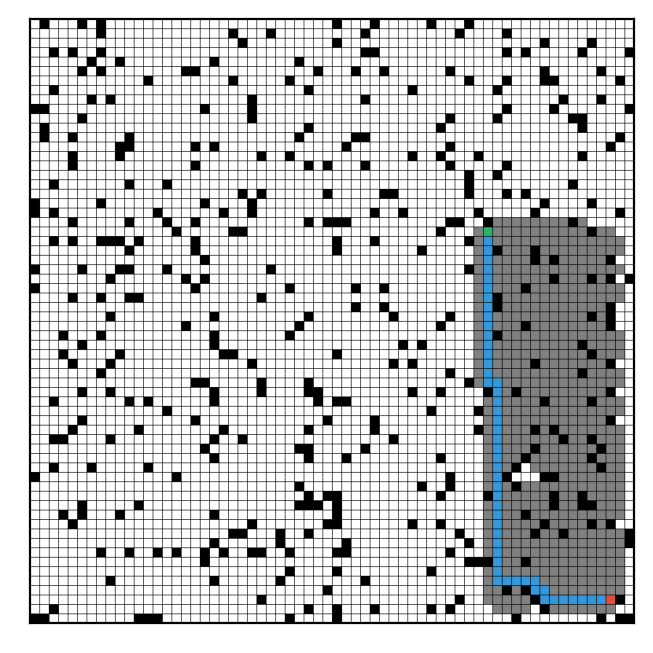

Map Update 1
Length 52
Nodes opened 259


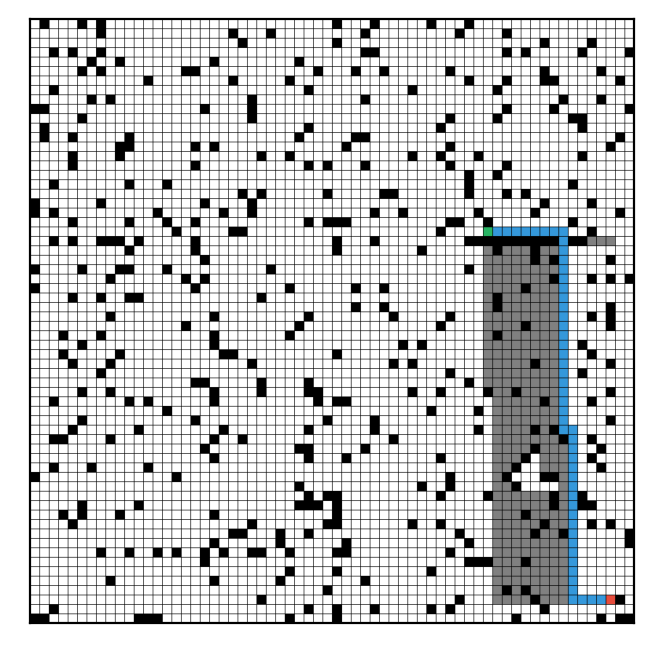

Elapsed Time 0.7098431587219238

Original Map
Length 32
Nodes opened 271


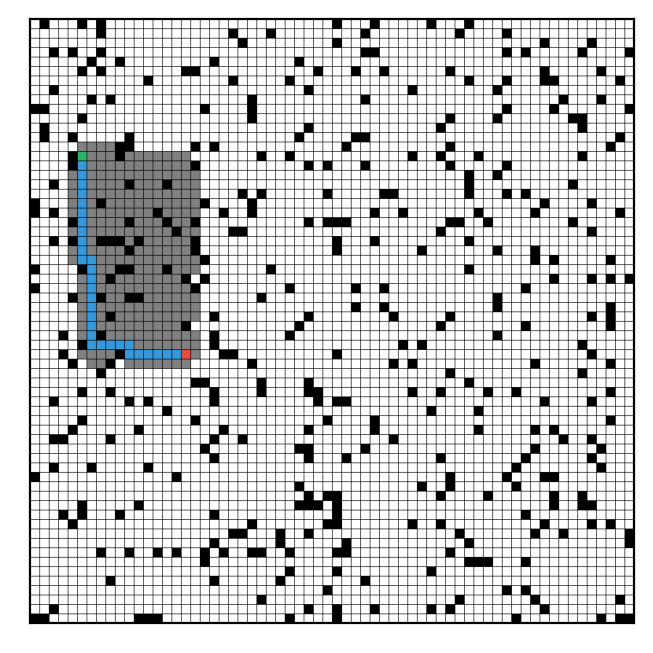

Map Update 1
Length 32
Nodes opened 63


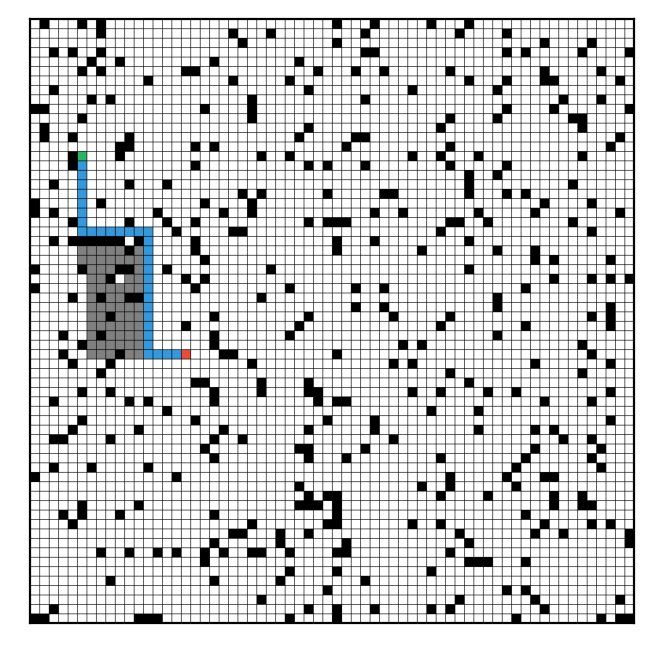

Elapsed Time 0.6319482326507568

Original Map
Length 70
Nodes opened 1194


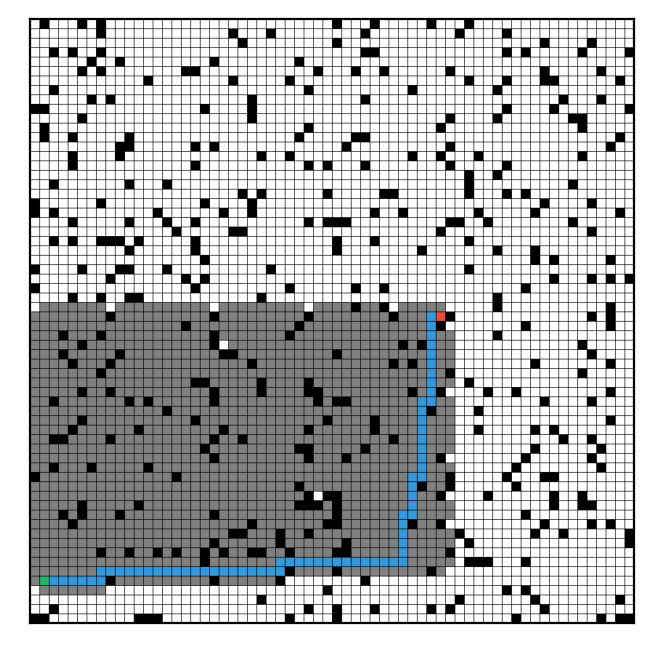

Map Update 1
Length 70
Nodes opened 24


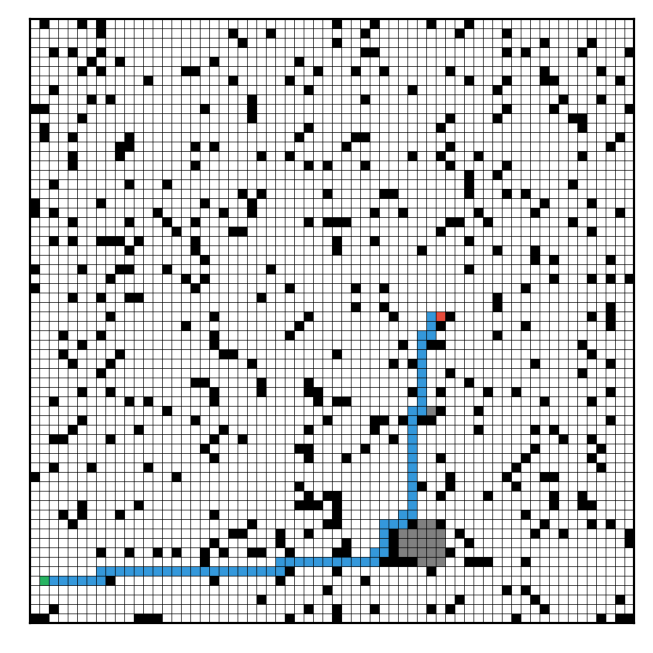

Elapsed Time 0.8447251319885254

Original Map
Length 31
Nodes opened 213


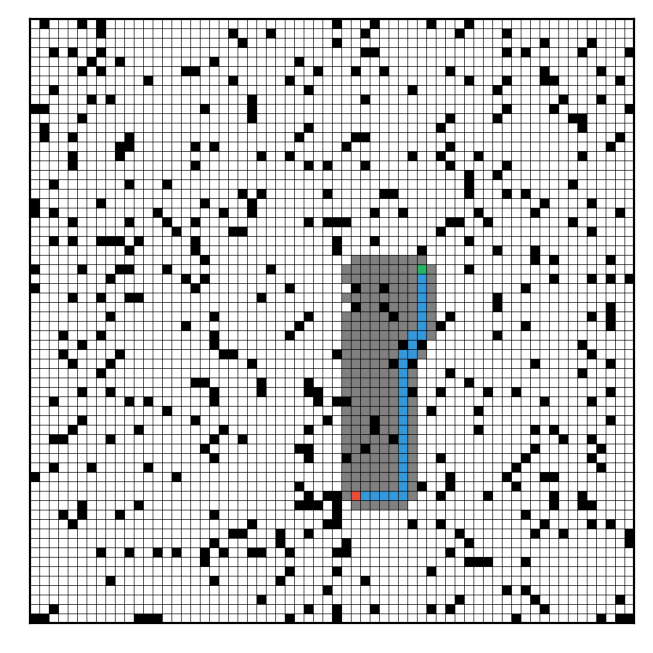

Map Update 1
Length 33
Nodes opened 124


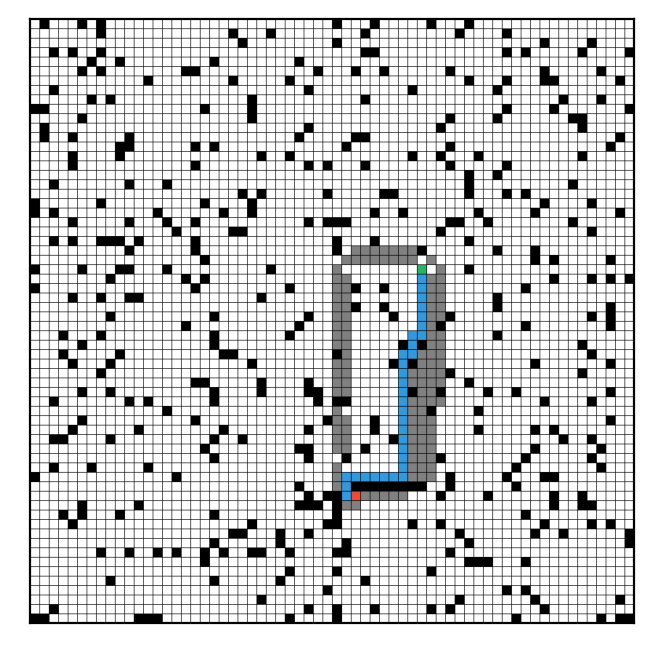

Elapsed Time 0.6057665348052979

Original Map
Length 59
Nodes opened 785


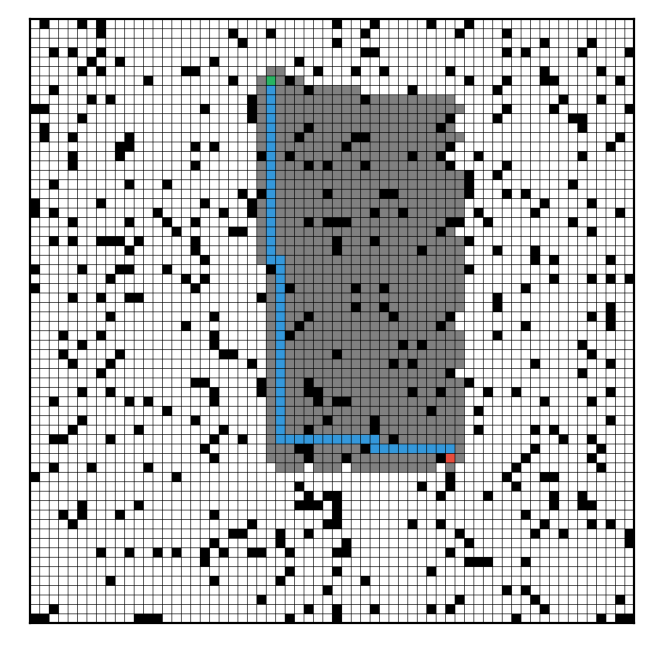

Map Update 1
Length 59
Nodes opened 101


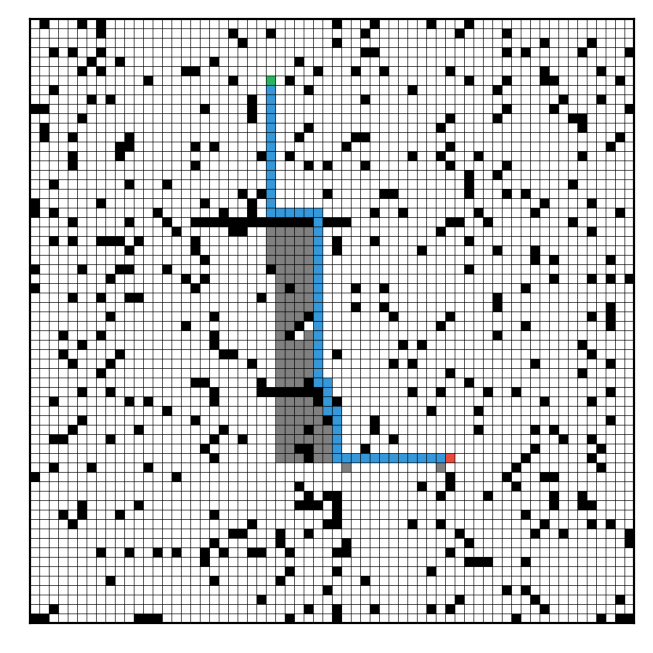

Elapsed Time 0.6880755424499512



In [ ]:
res = test(lpa, '/content/maps/', 10, 64, True, manhattan_distance)

Пример запуска тестов для алгоритма D* Lite: задача движения агента к цели в частично наблюдаемой среде (на тех же картах, что и в предыдущем эксперименте). 

---



Original Map
Length 78
Nodes opened 1234


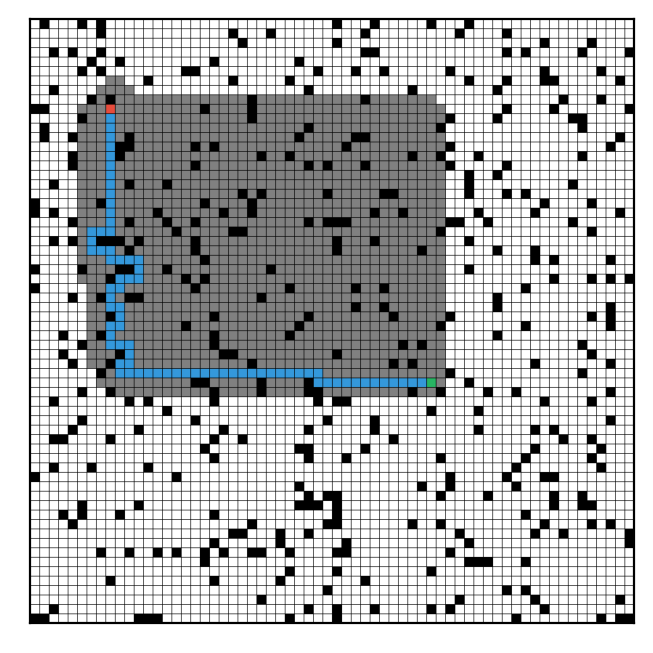

Map Update 1
Length 78
Nodes opened 1234


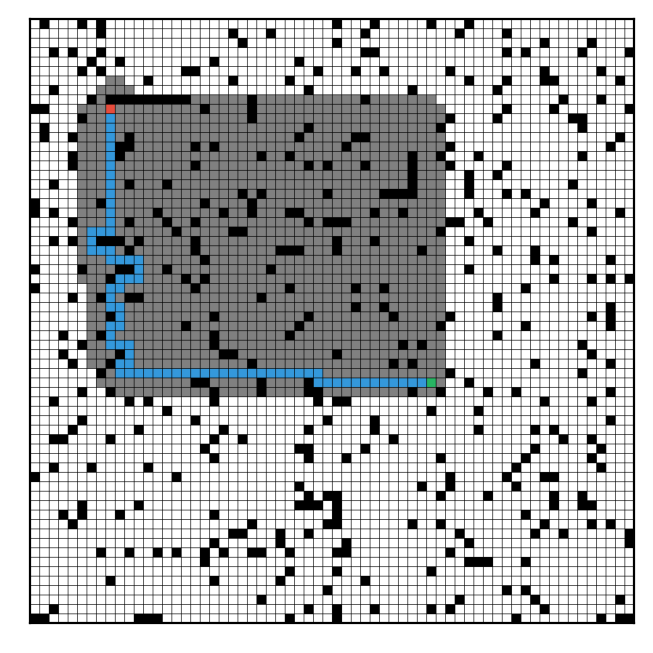

Elapsed Time 1.019467830657959

Original Map
Length 51
Nodes opened 483


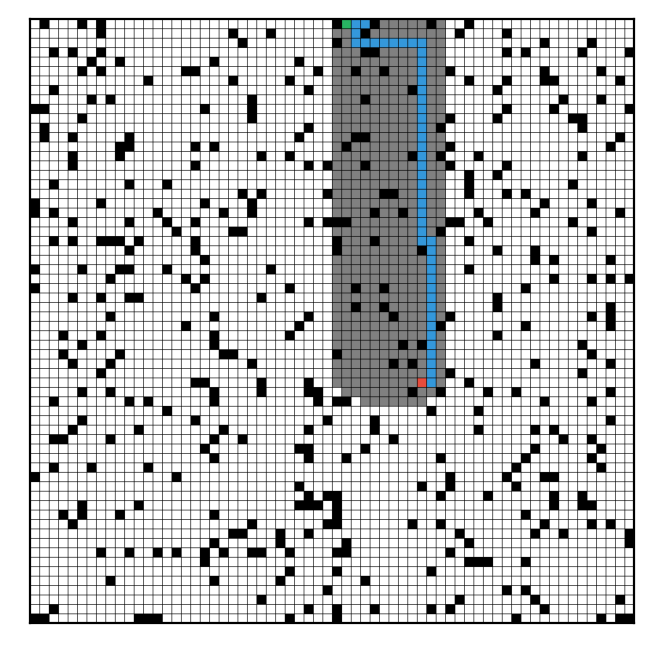

Map Update 1
Length 49
Nodes opened 454


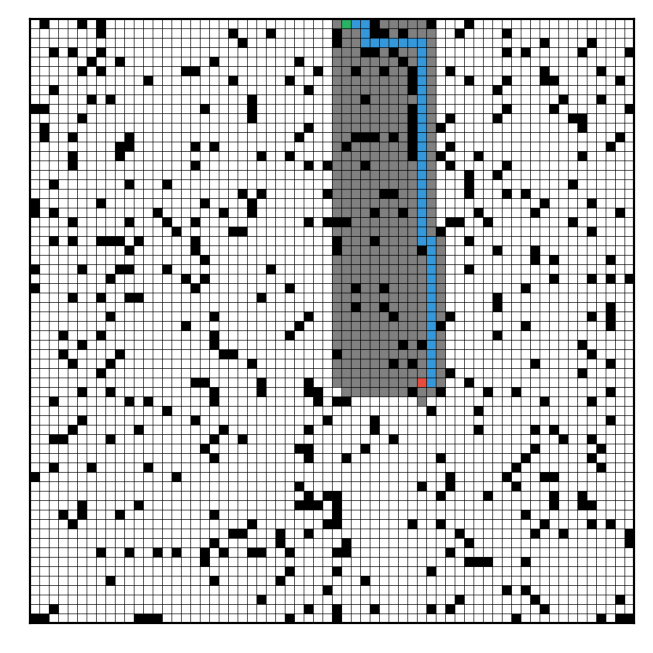

Elapsed Time 0.8514325618743896

Original Map
Length 58
Nodes opened 693


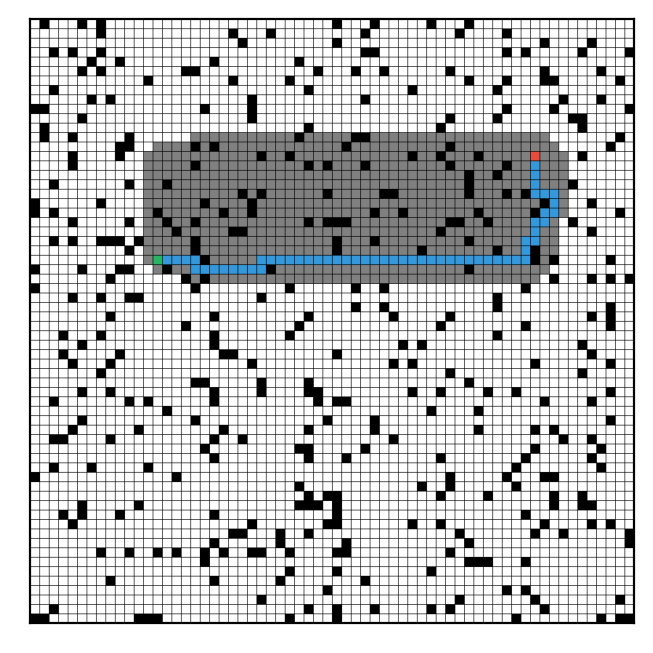

Map Update 1
Length 58
Nodes opened 693


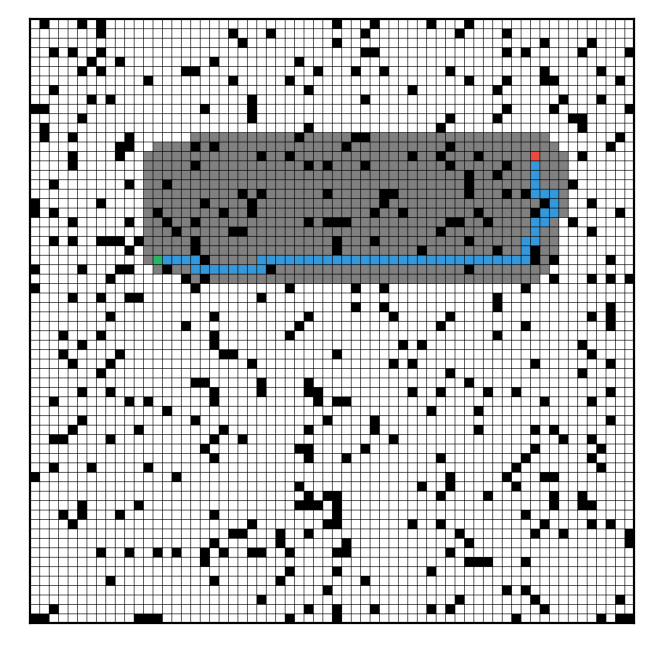

Elapsed Time 0.7675900459289551

Original Map
Length 102
Nodes opened 2683


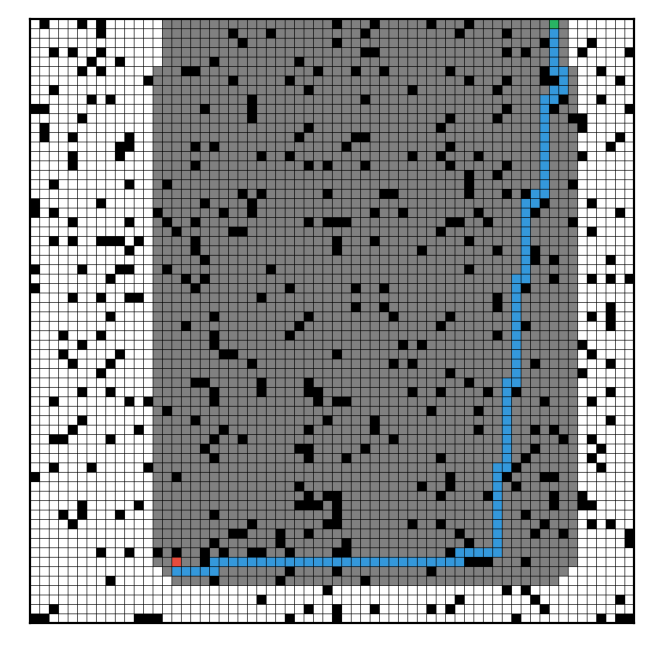

Map Update 1
Length 108
Nodes opened 2683


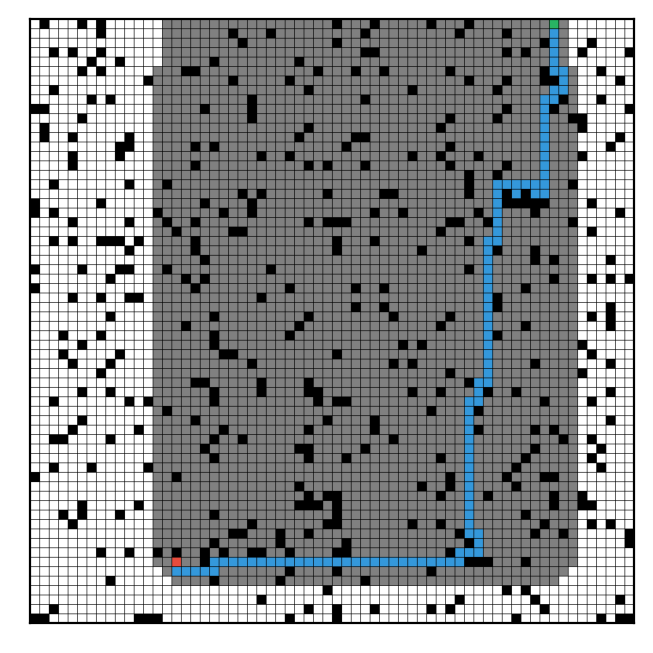

Elapsed Time 1.7272257804870605

Original Map
Length 33
Nodes opened 289


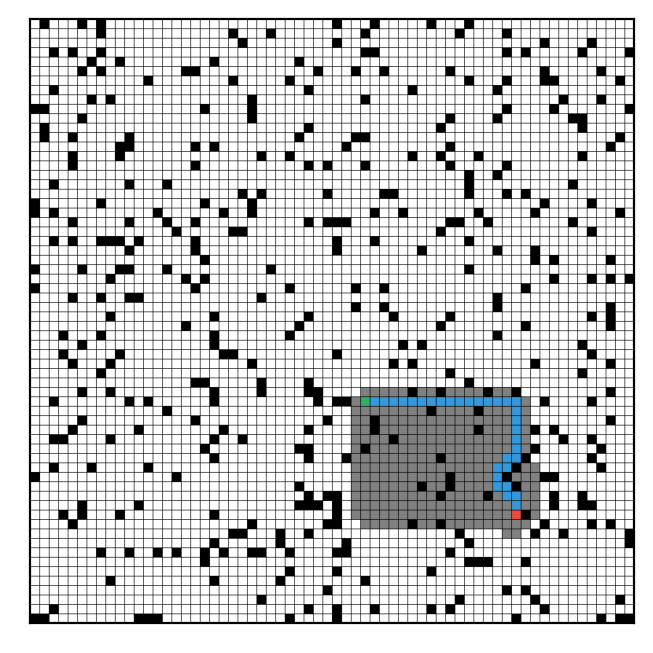

Map Update 1
Length 33
Nodes opened 289


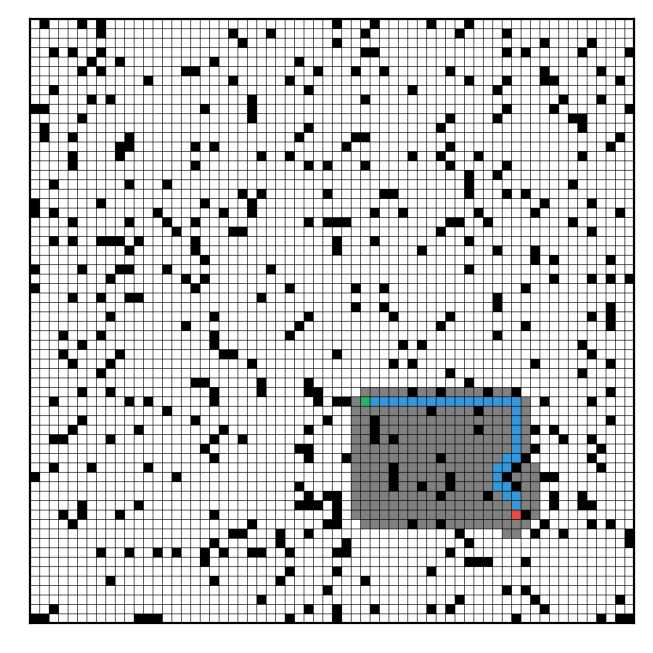

Elapsed Time 0.6556313037872314

Original Map
Length 55
Nodes opened 706


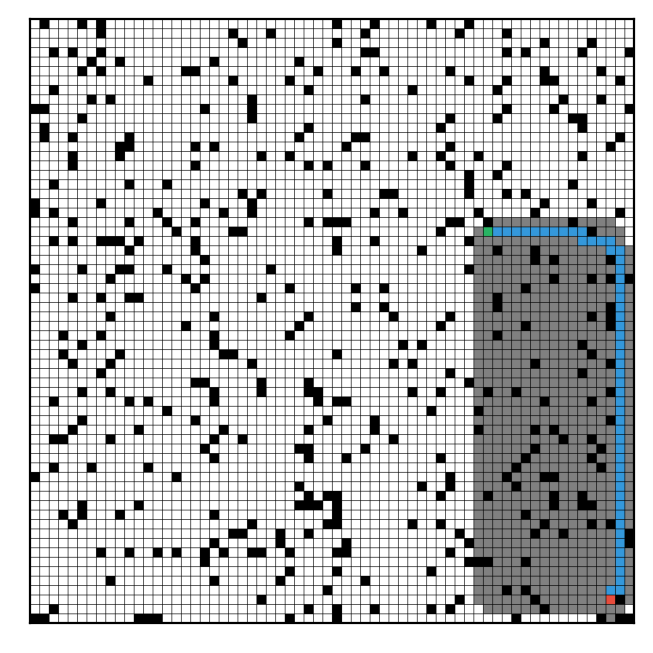

Map Update 1
Length 57
Nodes opened 713


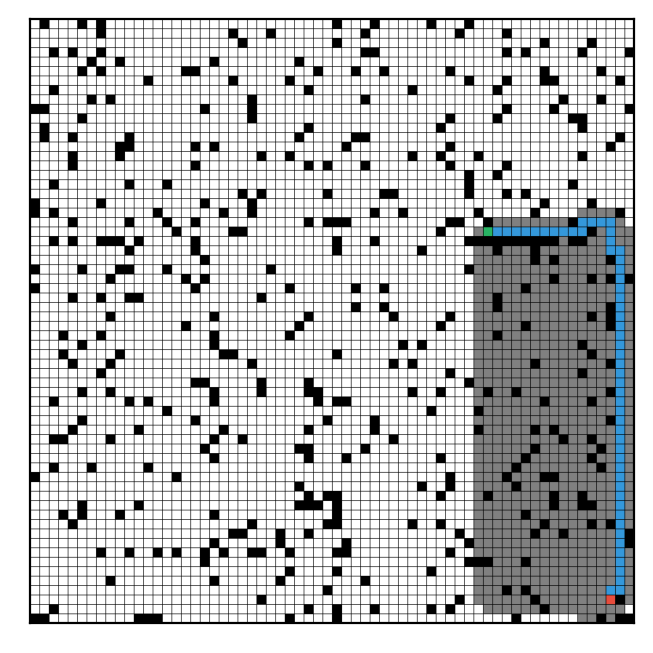

Elapsed Time 0.7825138568878174

Original Map
Length 41
Nodes opened 367


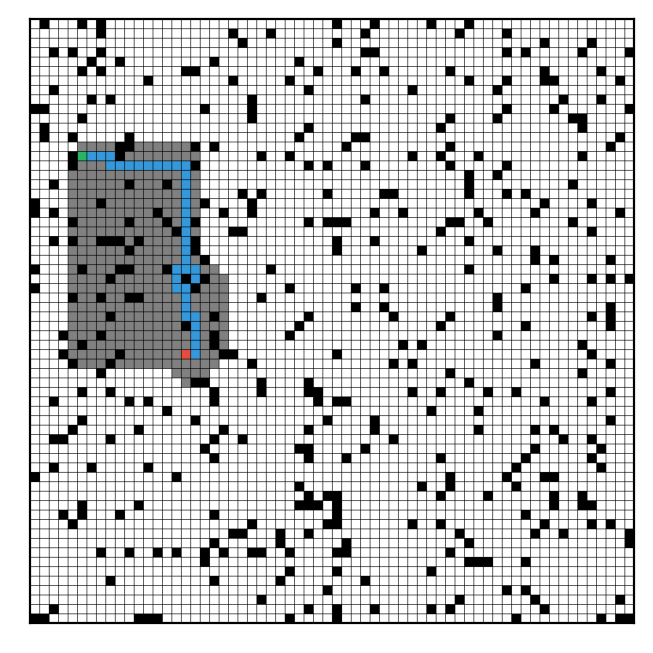

Map Update 1
Length 41
Nodes opened 367


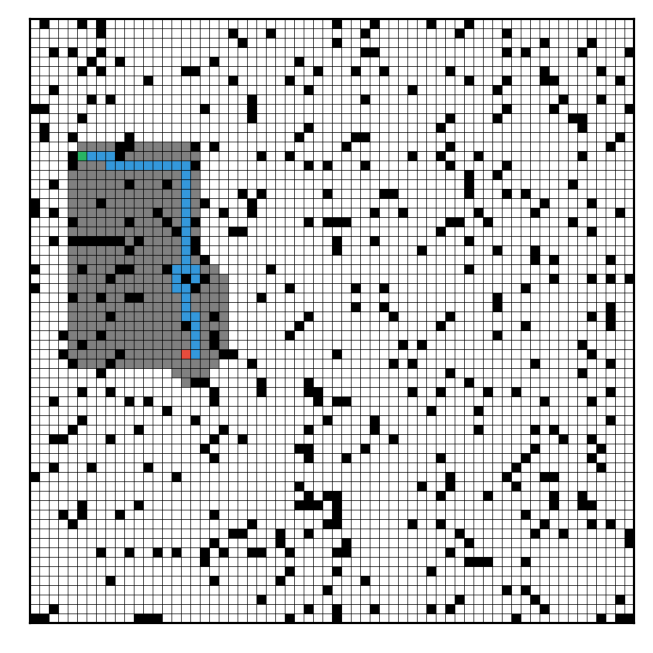

Elapsed Time 0.786623477935791

Original Map
Length 85
Nodes opened 1443


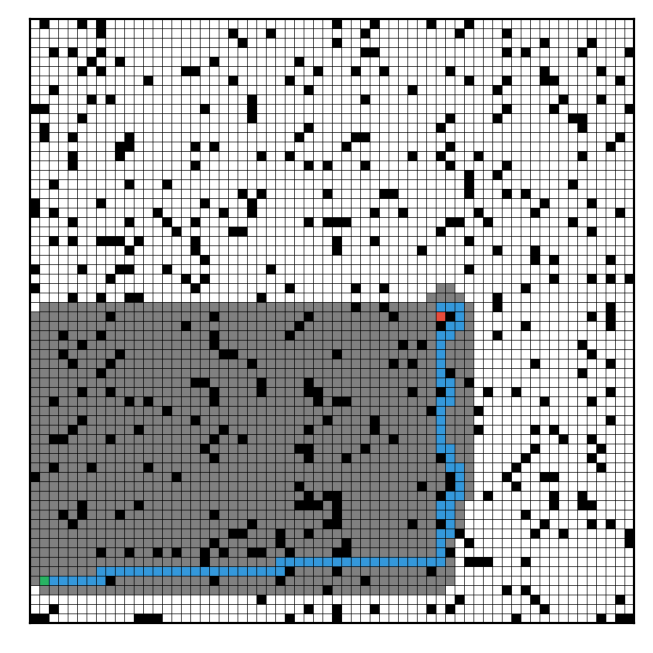

Map Update 1
Length 83
Nodes opened 1440


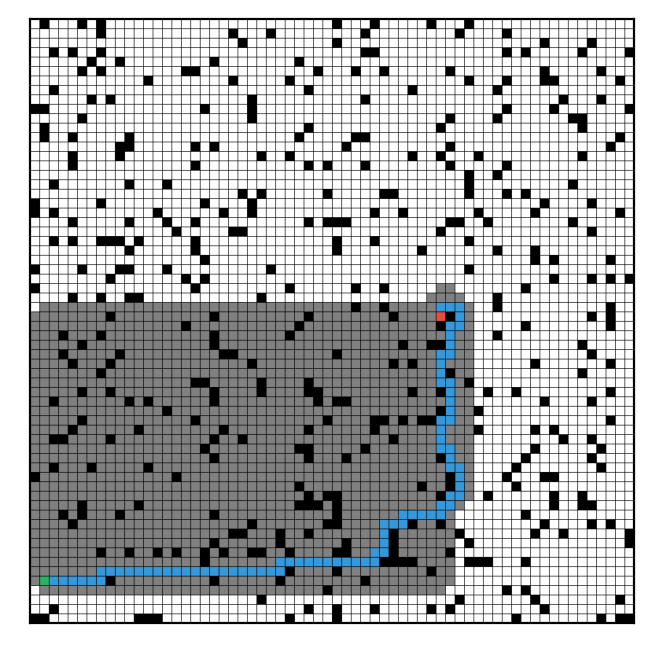

Elapsed Time 1.1072921752929688

Original Map
Length 32
Nodes opened 265


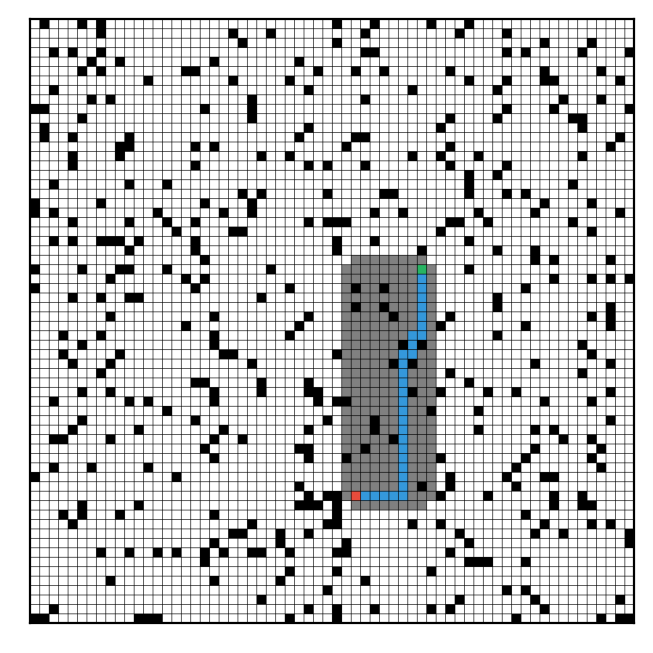

Map Update 1
Length 34
Nodes opened 271


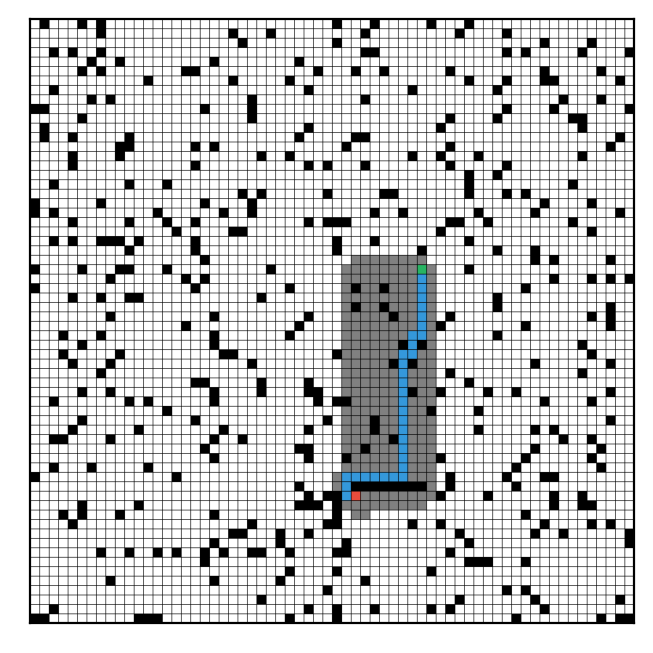

Elapsed Time 0.6412985324859619

Original Map
Length 70
Nodes opened 981


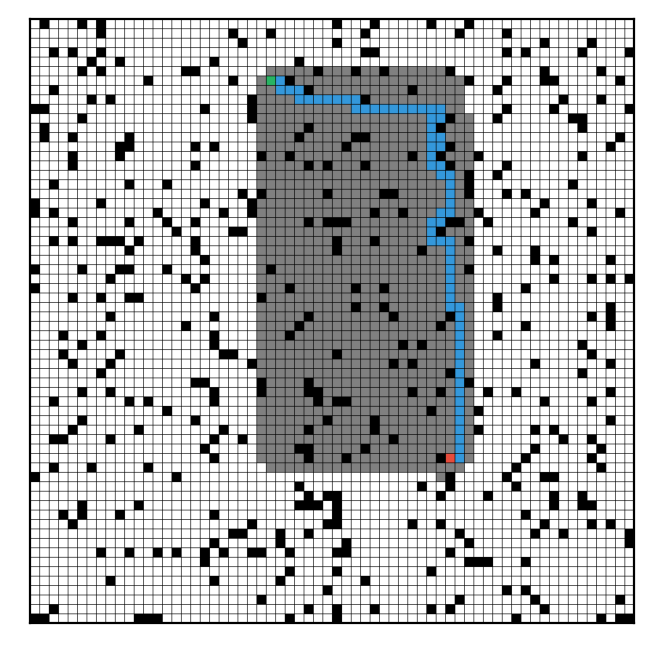

Map Update 1
Length 70
Nodes opened 981


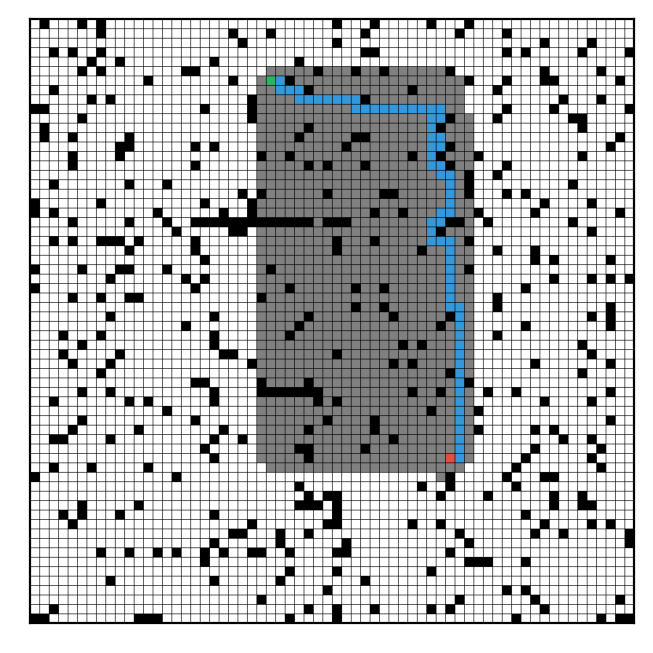

Elapsed Time 0.8742430210113525



In [ ]:
res = test(dstar, '/content/maps/', 10, 64, True, manhattan_distance)